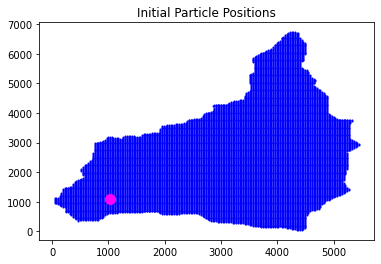

In [2]:
# DTRM Survival Model

# Parcel speeds using a Manning's type model
#   V = (1.5/N)*R**(2/3)*S**(1/2)


#       INCREASES DOWNWARD, X INCREASES RIGHTWARD
#
#     XP(),YP()    ARE X AND Y COORDINATES OF PARTICLES
#     XG(),YG()    ARE X AND Y COORDINATES OF GRID
#  HEAD()       IS HEAD DISTRIBUTION DEFINED ON THE GRID
#  VX()         IS COMPUTED VELOCITY IN DIRECTION OF FLOW
#  VY()         IS COMPUTED TIME OF TRAVEL TO NEXT CELL IN DIRECTION OF FLOW
#  DMAP()       IS FLOW DIRECTION ARRAY IN 8-DIRECTIONS; 
#                 DIRECTION 0 IS OUTLET
#                 DIRECTION 9 IS A PIT
#                 DIRECTION -1 IS NO-FLOW CELL
#                 ENTIRE MODEL IS SURROUNDED BY DIRECTION 0 CELLS, THESE ARE IGNORED
#
#                
#  DELATX       IS GRID SPACING
#  DELTAT       IS TIME INCREMENT
#  NP           ARE NUMBER OF PARTICLES
#
#  Y - COORDINATE OF GRID IS ASSOCIATED WITH THE "ROW" INDEX
#  X - COORDINATE OF GRID IS ASSOCIATED WITH THE "COLUMN" INDEX
#
#  Y - INCREASES DOWNWARD
#  X - INCREASES RIGHTWARD
#
#  THE UPPER LEFT HAND CORNER OF THE HEAD ARRAY IS X=0,Y=0
#  THE LOWER RIGHT HAND CORNER OF THE HEAD ARRAY IS X=XMAX,Y=YMAX
#
# DECLARE ARRAYS


###########################################################
#### import memory management tools (garbage collector) ###
###########################################################
import gc
gc.collect();
###########################################################
#### import plotting support packages                  ####
###########################################################
import matplotlib.pyplot as plt
###########################################################
#### import random number generator for particle death ####
###########################################################
import random 

def mappart(plotfileout,title,xpos,ypos,xsink,ysink):
    import matplotlib.pyplot as plt
# build a plot of particle positions and outlet position
    plt.figure()
    plt.title(title)
    plt.scatter(xpos, ypos, s=1, color='blue')
    plt.scatter(xsink, ysink, s=100, color='magenta')
    plt.savefig(plotfileout);
    return

####################################
#### Specify the input file name ###
####################################
filename = "sta08057320.mat.dat" # dtrm input file

#################################
#### Read the DTRM input file ###
#################################
afile = open(filename,"r")  # connect to the file
amatrix = [] # null object to store read
bmatrix = []
rowNumA = 0
rowNumB = 0
aflag = 1
bflag = 1
verbose = 1
substrings_to_check = ["DIRECTIVE","VERBOSE","TERSE","DMAP","SMAP","TMAP"]
for line in afile:
# if line contains substrings then first line
    if any(substring in line for substring in substrings_to_check):
#    if "DIRECTIVE" in line:      
        directive = line.strip().split()[0]
#        print('Row : ',rowNumA,'Contents : ',line)
        rowNumA += 1
        continue
    if rowNumA == 1:  # this is second line
        nrow = line.strip().split()[0]
        ncol = line.strip().split()[1]
#        print(nrow,ncol)
#        print('Row : ',rowNumA,'Contents : ',line.strip().split())
        aflag = 0 # read into amatrix
        rowNumA += 1
        continue
####################################
#### Check for seperator fields ####
#### Read input matrices to EOL ####
####################################
    if "CMAN,FDEEP,NMAN" in line: # seperates 
        cman  = line.strip().split()[0]
        fdeep = line.strip().split()[1]
        nman  = line.strip().split()[2]
        alife = line.strip().split()[3]
#        print('Row : ',rowNumA,'Contents : ',line)
#        rowNumA += 1
        aflag = 1
        bflag = 1
        continue
    if "DX,DT,TMAX,D1" in line: # seperates 
        dx   = line.strip().split()[0]
        dt   = line.strip().split()[1]
        tmax = line.strip().split()[2]
        d1   = line.strip().split()[3]
        dyt  = line.strip().split()[4]
        dxt  = line.strip().split()[5]
#        print('Row : ',rowNumA,'Contents : ',line)
#        rowNumA += 1
        aflag = 1
        bflag = 1
        continue
    if "NP,PRINT_N" in line: # seperates 
        np   = line.strip().split()[0]
        npt   = line.strip().split()[1]
#        print('Row : ',rowNumA,'Contents : ',line)
        aflag = 1
        bflag = 0 # read into bmatrix 
        continue
    if "outlet loc" in line: # seperates 
        nrout   = line.strip().split()[0]
        ncout   = line.strip().split()[1]
        elevout = line.strip().split()[2]
#########################################
#### reindex to start from 0 index   ####
#########################################
        nrout = int(nrout) - 1
        ncout = int(ncout) - 1
#        print('Row : ',rowNumA,'Contents : ',line)
        aflag = 1
        bflag = 1
    elif aflag == 0:
        amatrix.append([float(n) for n in line.strip().split()])
#        print('Row : ',rowNumA,'Contents : ',line.strip().split())
        rowNumA += 1
    elif bflag == 0:
        bmatrix.append([float(n) for n in line.strip().split()])
#        print('Row : ',rowNumB,'Contents : ',line.strip().split())
        rowNumB += 1
#    print("loop bottom")
afile.close() # Disconnect the file
#################################
#### Echo to DTRM output file ###
#################################
fileout = filename.replace("mat","out")
afile = open(fileout,"w")  # connect to the file
afile.write("DTRM-Survival Jupyter/iPython")
afile.write("\n  INPUT FILENAME : " + repr(filename))
afile.write("\n OUTPUT FILENAME : " + repr(fileout))
afile.write("\n  OUTPUT DENSITY : " + directive)
afile.write("\n            ROWS : " + repr(int(nrow)))
afile.write("\n         COLUMNS : " + repr(int(ncol)))
afile.write("\n            CMAN : " + repr(float(cman)))
afile.write("\n           FDEEP : " + repr(float(fdeep)))
afile.write("\n            NMAN : " + repr(float(nman)))
afile.write("\n           ALIFE : " + repr(float(alife)))
afile.write("\n              DX : " + repr(float(dx)))
afile.write("\n              DT : " + repr(float(dt)))
afile.write("\n            TMAX : " + repr(float(tmax)))
afile.write("\n              D1 : " + repr(float(d1)))
afile.write("\n             DYT : " + repr(float(dyt)))
afile.write("\n             DXT : " + repr(float(dxt)))
afile.write("\n NUMBER PARTICLES: " + repr(int(np)))
afile.write("\n PRINT FREQUENCY : " + repr(int(npt)))
afile.write("\n      OUTLET ROW : " + repr(int(nrout)))
afile.write("\n   OUTLET COLUMN : " + repr(int(ncout)))
afile.write("\nOUTLET ELEVATION : " + repr(float(elevout)))
afile.close()
##############################################
#### structure the amatrix and bmatrix    ####
#### arrays into index accessible arrays  ####
##############################################
ncol = int(ncol)
nrow = int(nrow)
#print(nrow,ncol)
head = [[0.0 for j in range(ncol)] for i in range(nrow)]
dmap = [[-999.0 for j in range(ncol)] for i in range(nrow)]
pmap = [[0.0 for j in range(ncol)] for i in range(nrow)]
pbmap = [[0.0 for j in range(ncol)] for i in range(nrow)]
nr2r = len(amatrix)
nc2r = len(amatrix[0])
#print(nr2r,nc2r)
col2assign = 0
row2assign = 0
for ir2r in range(nr2r): #i is row to assign
    for jc2r in range(nc2r): #j is column to assign
#        print("rc2r ",ir2r,jc2r,row2assign,col2assign)
        head[row2assign][col2assign] = float(amatrix[ir2r][jc2r])
        pmap[row2assign][col2assign] = float(bmatrix[ir2r][jc2r])
        pbmap[row2assign][col2assign] = float(bmatrix[ir2r][jc2r])
        col2assign += 1
        if col2assign >= ncol:
            col2assign = 0
            row2assign += 1
            break
##############################################
#### get min/max and mask count and report ###
##############################################
maxhead = 0.00000001
minhead = 10000000.0
countP = 0.0
for irow in range(nrow):
    if max(head[irow]) > maxhead:
        maxhead = max(head[irow])
    if min(head[irow]) < minhead:
        minhead = min(head[irow])
    countP = countP + sum(pbmap[irow])

afile = open(fileout,"a")  # connect to the file; append
afile.write("\n   MIN ELEVATION : " + repr(float(minhead)))
afile.write("\n   MAX ELEVATION : " + repr(float(maxhead)))
afile.write("\n      MASK COUNT : " + repr(int(countP)))
afile.close()

##############################################
#### build grid locations for cell centers ###
##############################################
xg  = [0.0  for i in range(ncol)]
yg  = [0.0  for i in range(nrow)]
xbg = [0.0  for i in range(ncol)]
ybg = [0.0  for i in range(nrow)]
dx  = float(dx)

yg[0]  =0.5*dx
xg[0]  =0.5*dx
ybg[0] =0.5*dx
xbg[0] =0.5*dx
for irow in range(1,nrow):
    yg[irow]=yg[irow-1]+dx
    ybg[irow]=ybg[irow-1]+dx
for jcol in range(1,ncol):
    xg[jcol]=xg[jcol-1]+dx
    xbg[jcol]=xbg[jcol-1]+dx
if directive == 'VERBOSE':
    afile = open(fileout,"a")  # connect to the file; append
    afile.write("\n GRID CELL LOCATIONS : \n ICELL XGRID YGRID ")
    cellcount=1
    for irow in range(nrow):
        for jcol in range(ncol):
            afile.write('\n ' + repr(cellcount) + ' ' + repr(round(xg[jcol],3)) + ' ' + repr(round(yg[irow],3)))
            cellcount += 1
    afile.close()
############ memory management ###############
del amatrix    # release objects to free RAM #
del bmatrix    # release objects to free RAM #
gc.collect();  # force garbage collection    #
##############################################

##############################################
#### locate the outlet in the grid system ####
##############################################
xout=xg[int(ncout)]
yout=yg[int(nrout)]
xmin=xg[0]
ymin=yg[0]
xmax=xg[ncol-1]+dx
ymax=yg[nrow-1]+dx
afile = open(fileout,"a")  # connect to the file; append
afile.write("\n SUMMARY IN GRID COORDINATES ")
afile.write("\n    (X,Y) OUTLET : " + repr(float(xout)) + "," + repr(float(yout)) )
afile.write("\n     (XMIN,YMIN) : " + repr(float(xmin)) + "," + repr(float(ymin)) )
afile.write("\n     (XMAX,YMAX) : " + repr(float(xmax)) + "," + repr(float(ymax)))
afile.close()

########################################################################
#### convert particle map into an attribute array (i.e. alive/dead) ####
########################################################################
np  = 0 # particle count
ip  = 0 # particle index
lox = 0 # locaton outlet x
loy = 0 # location outlet y
countP = int(countP)
xp   = [0.0  for i in range(countP)] # location x of particle ip
yp   = [0.0  for i in range(countP)] # location y of particle ip
xps  = [0.0  for i in range(countP)] # start location x of particle ip
yps  = [0.0  for i in range(countP)] # start location y of particle ip
tp   = [0.0  for i in range(countP)] # location t of particle ip
wp   = [0.0  for i in range(countP)] # attribute w of particle ip
for irow in range(nrow):
    for jcol in range(ncol):
        if pbmap[irow][jcol] == 1.0:
            xp[ip]=xg[jcol]
            yp[ip]=yg[irow]
            tp[ip]=0.0
            wp[ip]=1.0 # make alive
# add start locations to xps,yps for particle ip
            xps[ip]=xg[jcol]
            yps[ip]=yg[irow]
            np += 1
            ip += 1
        else:
            xbg[jcol]= -1e9 # large negative float to indicate boundary
            ybg[irow]= -1e9 # large negative float to indicate boundary
        if xg[jcol] == xout and yg[irow] == yout : # check if outlet
            lop = ip-1
            lox = jcol
            loy = irow
afile = open(fileout,"a")  # connect to the file; append
afile.write("\n SUMMARY OF PARTICLE ARRAY CALCULATIONS ")
afile.write("\n            PARTICLE ARRAY LENGTH : " + repr(np))
afile.write("\n            PARTICLE INPUT COUNT  : " + repr(countP))
afile.write("\n            OUTLET      (LOX,LOY) : " + repr(float(lox)) + "," + repr(float(loy)))
afile.write("\n  OUTLET INDEX IN PARTICLE ARRAY  : " + repr(lop))
afile.close()

################################
### DEBUGGING VERBOSE OUTPUT ###
################################
if directive == 'VERBOSE':
    afile = open(fileout,"a")  # connect to the file; append
    afile.write("\n PARTICLE START LOCATIONS : \n IPART XPART YPART ")
    cellcount=1
    for ip in range(np):
        afile.write('\n ' + repr(ip) + ' ' + repr(round(xp[ip],3)) + ' ' + repr(round(yp[ip],3)))
    afile.close()
# build a plot of particle positions and outlet position
plotfileout = filename.replace("mat.dat","000.png")
#    plt.figure()
plottitle="Initial Particle Positions"
#    plt.scatter(xps, yps, s=1, color='blue')
#    plt.scatter(xout, yout, s=100, color='magenta')
#    plt.savefig(plotfileout);
mappart(plotfileout,plottitle,xps,yps,xout,yout)  

#################################
#### compute velocity field  ####
#################################
vx  = [[0.0 for j in range(ncol)] for i in range(nrow)] # 0 lists to store velocity
vy  = [[0.0 for j in range(ncol)] for i in range(nrow)] # 0 lists to store velocity
cman = float(cman)
nman = float(nman)
fdeep = float(fdeep)

def getdirs(head,vx,vy,nrow,ncol,cman,rman,dx,fdepth,pbmap,dmap,lox,loy,xg,yg):
    #########################
    #### Some constants  ####
    #########################
    import math
    dxinv=1.0/(dx*3.25) # XY distances in feet
    conveyance=(cman/rman)*fdepth**(2./3.)
    channel=(cman/rman)*(2.0*fdepth)**(2./3.)
    dsqrtiv=1.0/math.sqrt(2.0)
    d = [-10.0 for i in range(9)]
###################################
###         Directions         ####
###                            ####
###     1       2        3     ####
###                            ####
###     4       0        5     ####
###                            ####
###     6       7        8     ####
###                            ####
###################################    
    # interior cells
    for irow in range(1,nrow-1):
        for jcol in range(1,ncol-1):
            d[0]=-1.0
            d[1]=(head[irow][jcol]-head[irow-1][jcol-1])*pbmap[irow-1][jcol-1]
            d[2]=(head[irow][jcol]-head[irow-1][jcol  ])*pbmap[irow-1][jcol  ]
            d[3]=(head[irow][jcol]-head[irow-1][jcol+1])*pbmap[irow-1][jcol+1]
            d[4]=(head[irow][jcol]-head[irow  ][jcol-1])*pbmap[irow  ][jcol-1]
            d[5]=(head[irow][jcol]-head[irow  ][jcol+1])*pbmap[irow  ][jcol+1]
            d[6]=(head[irow][jcol]-head[irow+1][jcol-1])*pbmap[irow+1][jcol-1]
            d[7]=(head[irow][jcol]-head[irow+1][jcol  ])*pbmap[irow+1][jcol  ]
            d[8]=(head[irow][jcol]-head[irow+1][jcol+1])*pbmap[irow+1][jcol+1]
            # check bigger then zero
            big = 0
            idir = 0
            for ii in range(1,9):
                if d[ii] > big:
                    big = d[ii]
                    idir = ii
            # assign direction to dmap; if boundary cell ignore
            if pbmap[irow][jcol] > 0:
                dmap[irow][jcol]=idir*pbmap[irow][jcol]
            else:
                dmap[irow][jcol]=idir*pbmap[irow][jcol]-10.0
            # compute speed and time
            if   idir == 1:
                vx[irow][jcol]=conveyance*math.sqrt(d[1]*dxinv*dsqrtiv)
                vy[irow][jcol]=math.sqrt(2.0)*dx*3.25/vx[irow][jcol]
            elif idir == 2:   
                vx[irow][jcol]=conveyance*math.sqrt(d[2]*dxinv)
                vy[irow][jcol]=dx*3.25/vx[irow][jcol]
            elif idir == 3:
                vx[irow][jcol]=conveyance*math.sqrt(d[3]*dxinv*dsqrtiv)
                vy[irow][jcol]=math.sqrt(2.0)*dx*3.25/vx[irow][jcol]
            elif idir == 4:
                vx[irow][jcol]=conveyance*math.sqrt(d[4]*dxinv)
                vy[irow][jcol]=dx*3.25/vx[irow][jcol] 
            elif idir == 5:
                vx[irow][jcol]=conveyance*math.sqrt(d[5]*dxinv)
                vy[irow][jcol]=dx*3.25/vx[irow][jcol]  
            elif idir == 6:
                vx[irow][jcol]=conveyance*math.sqrt(d[6]*dxinv*dsqrtiv)
                vy[irow][jcol]=math.sqrt(2.0)*dx*3.25/vx[irow][jcol] 
            elif idir== 7:
                vx[irow][jcol]=conveyance*math.sqrt(d[7]*dxinv)
                vy[irow][jcol]=dx*3.25/vx[irow][jcol]  
            elif idir == 8:  
                vx[irow][jcol]=conveyance*math.sqrt(d[8]*dxinv*dsqrtiv)
                vy[irow][jcol]=math.sqrt(2.0)*dx*3.25/vx[irow][jcol] 
            elif idir == 0:
# these are sinks or plateaus, route to outlet by cartesian path
                vy[irow][jcol]=-2.
                vx[irow][jcol]   = head[irow][jcol]-head[loy][lox]
                dist=math.sqrt( (xg[jcol]-xg[lox])**2 + (yg[irow]-yg[loy])**2 )
                if dist != 0.0:
                    vx[irow][jcol]   = conveyance*math.sqrt(vx[irow][jcol]*dxinv*dsqrtiv)
                    vy[irow][jcol]   = math.sqrt(2.0)*dist*3.25/vx[irow][jcol] 
    # if outlet cell override direction 
    dmap[loy][lox]=0*pbmap[loy][lox]
    vx[loy][lox]=0.0
    vy[loy][lox]=0.0
    return()

getdirs(head,vx,vy,nrow,ncol,cman,nman,dx,fdeep,pbmap,dmap,lox,loy,xg,yg)

################################
### DEBUGGING VERBOSE OUTPUT ###
################################
if directive == 'VERBOSE' or directive == 'DMAP':
    debugfile = filename.replace("mat.dat","dbmap.dat")
    afile = open(debugfile,"w")  # connect to the file; overwrite
# direction code
    afile.write("DIRECTION MAP : \n IROW : JCOL :    X(JCOL) :    Y(IROW) : ELEVATION : DIRECTION :   SPEED : PATH-TIME : PBMAP ")
    for irow in range(nrow):
        for jcol in range(ncol):
            afile.write('\n  %3i :  %3i : %10.3f : %10.3f :   %7.2f :      %4i : %7.2f :   %7.2f : %7.2f ' % (irow,jcol,xg[jcol],yg[irow],\
                        head[irow][jcol],dmap[irow][jcol],vx[irow][jcol],vy[irow][jcol],pbmap[irow][jcol]))
            #afile.write('\n ' + repr(irow) + ' ' + repr(jcol) + ' ' + repr(round(xg[jcol],3)) + ' ' + repr(round(yg[irow],3)) + ' ' \
             #           + repr(round(head[irow][jcol],3)) + ' ' + repr(round(dmap[irow][jcol],3))+ ' ' + repr(round(vx[irow][jcol],3)) \
              #          + ' ' + repr(round(vy[irow][jcol],3)))
    afile.close()
    
##################################################
#### regular output static contents completed ####
##################################################
afile = open(fileout,"a")  # connect to the file; append
afile.write("\n  VELOCITY MAPS BUILT ")
afile.write("\n  PARTICLE MAPS BUILT ")
afile.write("\n DIRECTION MAPS BUILT ")

maxvx = 0.00000001 # Different floats on purpose to force different memory addresses
maxvy =  0.0000001
minvx = 10000000.0
minvy =  1000000.0
for irow in range(nrow):
    for jcol in range(ncol):
        if vx[irow][jcol] > maxvx:
            maxvx = vx[irow][jcol]
        if vy[irow][jcol] > maxvy:
            maxvy = vy[irow][jcol]
        if vx[irow][jcol] < minvx:
            minvx = vx[irow][jcol]
        if vy[irow][jcol] < minvy:
            minvy = vy[irow][jcol]
afile.write("\n   MIN VX VALUE = : " + repr(round(minvx,3)))
afile.write("\n   MIN VY VALUE = : " + repr(round(minvy,3)))
afile.write("\n   MAX VX VALUE = : " + repr(round(maxvx,3)))
afile.write("\n   MAX VY VALUE = : " + repr(round(maxvy,3)))

afile.close()

def findpart(xp,yp,xg,yg,nrows,ncols,ip):
# all arrays must exist, lpx and lpy are returned in call
# set search distance
    big = 1.0e9
# locate nearest grid point
    dist1=big
    dist2=big
    for irow in range(nrows):
        for jcol in range(ncols): 
            dist2 = (xp[ip]-xg[jcol])**2 + (yp[ip]-yg[irow])**2
            if dist2 < dist1:
                dist1 = dist2
                lpx=jcol
                lpy=irow
    return(lpy,lpx) # should operate on arrays in place

def movepart(xp,yp,xg,yg,vx,vy,nrow,ncol,ip,dmap,tp,lox,loy):
# function to move a single particle of index ip in the particle attribute array
# locate the particle cell index
    ploc=findpart(xp,yp,xg,yg,nrow,ncol,ip)
    lpx=ploc[1]
    lpy=ploc[0]
# find direction to move
    try: # find direction to move
        dmove=int(dmap[lpy][lpx])
    except: # raise exception and exit
        print("FailDMOVE at",lpy,lpx)
#        exit()
    ##print("dmove",dmove,lpx,lpy)
# find time to move
    try: # find time to move
        tmove=vy[lpy][lpx]
    except: # raise exception and exit
        print("FailTMOVE at",lpy,lpx)
#        exit()
        
        flag = 0
# move the particle 
    if dmove == 1: # left up - valid
        xp[ip]=xg[lpx-1]
        yp[ip]=yg[lpy-1]
        tp[ip]=tp[ip]+tmove
    if dmove == 2: # up - fixed
        xp[ip]=xg[lpx  ]
        yp[ip]=yg[lpy-1]
        tp[ip]=tp[ip]+tmove
    if dmove == 3: # right up - fixed
        xp[ip]=xg[lpx+1]
        yp[ip]=yg[lpy-1]
        tp[ip]=tp[ip]+tmove
    if dmove == 4: # left - valid
        xp[ip]=xg[lpx-1]
        yp[ip]=yg[lpy  ]
        tp[ip]=tp[ip]+tmove
    if dmove == 5: # right - fixed
        xp[ip]=xg[lpx+1]
        yp[ip]=yg[lpy  ]
        tp[ip]=tp[ip]+tmove
    if dmove == 6: # left down - valid
        xp[ip]=xg[lpx-1]
        yp[ip]=yg[lpy+1]
        tp[ip]=tp[ip]+tmove
    if dmove == 7: # down - fixed
        xp[ip]=xg[lpx  ]
        yp[ip]=yg[lpy+1]
        tp[ip]=tp[ip]+tmove
    if dmove == 8: # right down - fixed
        xp[ip]=xg[lpx+1]
        yp[ip]=yg[lpy+1]
        tp[ip]=tp[ip]+tmove
    if dmove == 0: # outlet, sink, or plateau
        # check if outlet
        if xp[ip]== xg[lox] and yp[ip]==yg[loy]:
            tp[ip]=tp[ip]
            #print("OUTLET",ip,xp[ip],yp[ip],xg[lox],yg[loy])
        else: # must be a sink or plateau -- route to outlet
            #print("SUMP IN",ip,xp[ip],yp[ip],xg[lox],yg[loy])
            xp[ip]=xg[lox]
            yp[ip]=yg[loy]
            tp[ip]=tp[ip]+tmove
            #print("SUMP OUT",ip,xp[ip],yp[ip],xg[lox],yg[loy])
    if dmove == 9: # pit
        xp[ip]=xg[lox]
        yp[ip]=yg[loy]
        tp[ip]=tp[ip]+tmove
    if dmove == 10: # boundary
        print('ERROR -- ATTEMPTING TO MOVE IN BOUNDARY ARRAY')
        print('IP,LPX,LPY   =',ip,lpy,lpx)
        print('DMOVE,TMOVE  =',dmove,tmove)
    return()

In [3]:
######################################################
#### MOVE ALL CURRENT PARTICLES UNTIL EXIT OR DIE ####
######################################################
npmv = 0 #number of particles moved
#lpx = -1 # initial value lpx
#lpy = -2 # initial value lpy
alife = float(alife)
maxtry = int(0.2*(nrow*ncol)**0.5) # longest path guess.
print(maxtry)

40


PARTICLES MOVED SO FAR :  0 1
PARTICLES MOVED SO FAR :  2000 1
PARTICLES MOVED SO FAR :  4000 3
PARTICLES MOVED SO FAR :  6000 3
PARTICLES MOVED SO FAR :  8000 5
PARTICLES MOVED SO FAR :  10000 1
PARTICLES MOVED SO FAR :  12000 10
PARTICLES MOVED SO FAR :  14000 5
PARTICLES MOVED SO FAR :  16000 2
PARTICLES MOVED SO FAR :  18000 1
PARTICLES MOVED SO FAR :  20000 1
PARTICLE COUNT MOVED :  20639
MOVE LOOP ENDED


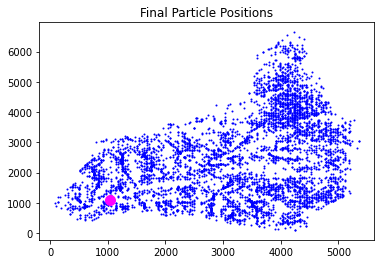

In [4]:
for ip in range(np):  # particle index loop
    for im in range(maxtry): # maximum steps to traverse area
        ploc=findpart(xp,yp,xg,yg,nrow,ncol,ip)
        ##print("particle loc B4 move: ",ip,xp[ip],yp[ip],tp[ip],ploc[0],ploc[1],dmap[ploc[0]][ploc[1]],head[ploc[0]][ploc[1]],loy,lox)
        movepart(xp,yp,xg,yg,vx,vy,nrow,ncol,ip,dmap,tp,lox,loy) # move particle one step
        ploc=findpart(xp,yp,xg,yg,nrow,ncol,ip) # locate particle
        ##print("particle loc AF move: ",ip,xp[ip],yp[ip],tp[ip],ploc[0],ploc[1],dmap[ploc[0]][ploc[1]],head[ploc[0]][ploc[1]],loy,lox)
        # check if it made it to outlet
        if ploc[0] == loy and ploc[1] == lox:
            #print("REACH OUTLET : ",ip,ploc[0],ploc[1],loy,lox,im)
            break #exit the traverse loop and process next particle
        # check for particle death
        death = random.random() # generate a random number in range (0,1)
        if death > alife:
            wp[ip]=0.0 # particle dies
            break #exit the traverse loop and process next particle
            print('die')
    if ip % 2000 == 0:
        print("PARTICLES MOVED SO FAR : ",ip,im)
    npmv += 1 
print("PARTICLE COUNT MOVED : ",npmv)
# build a plot of particle positions and outlet position
plotfileout = filename.replace("mat.dat","001.png")
#    plt.figure()
plottitle="Final Particle Positions"
#    plt.scatter(xps, yps, s=1, color='blue')
#    plt.scatter(xout, yout, s=100, color='magenta')
#    plt.savefig(plotfileout);
mappart(plotfileout,plottitle,xp,yp,xout,yout)  
print("MOVE LOOP ENDED")

In [5]:
#############################
#### sort the time array ####
#############################
# np=int(countP) ## repair accidental numpy naming
sorted_time = sorted(tp)
print(max(sorted_time),max(tp),sum(wp))
#len(sorted_time)
afile = open(fileout,"a")  # connect to the file; append
afile.write("\n CUMULATIVE ARRIVAL TIME DISTRIBUTION \n TIME  FRACTION  NUMBER")
gc.collect();  # force garbage collection    #
for ip in range(0,np,100):  # particle index loop
    # print(ip,sorted_time[ip]/20.0) ## activate to debug
    afile.write('\n  %10.3f  %10.3f  %10i ' % (sorted_time[ip]/20.0,float(ip)/float(np),ip))
afile.close()

5271.490748326969 5271.490748326969 14945.0


In [22]:
# Fit Leinhard Hydrograph
# Instructions:
# Load the merit function, provide filename from DTRM program.  
# Make initial guess using the result() function
# Supply to Powell Direction Set method, run until success or failure.  
# If success, insert solution into result function and plot.

def merit(x): 
# function to minimize to find values of tbar and shape
# x[0] == tbar
# x[1] == shape
# Script reads sta01234567.out.txt files and plots empirical cumulative and leinhard hydrographs and 
# systematically finds best values for tbar and shape

    filename = 'sta08057320.out.dat' # filename to read

    def prMat(amatrix):
    # prints the contents of amatrix to stdio
        howMany = len(amatrix) # get row count
        howWide = len(amatrix[0]) # get column count
        for irow in range(howMany):
            print(amatrix[irow])
        return()

################################
#   connect and read file      #
################################
    afile = open(filename,"r")  # connect and read file 
    amatrix = [] # null object to store read
    rowNumA = 0
    rowRead = 0
    substring1="ALIVE COUNT"
    for line in afile:
        if rowRead < 42: # skip first 42 rows
#        print(' Row Read: ',rowRead,' Content: ',line)
            rowRead = rowRead+1
        elif line.find(substring1) != -1: # check for last row
        #print('Last Row')
            continue
        else: # read the meaningful data
            amatrix.append([float(n) for n in line.strip().split()])
            rowNumA += 1
    afile.close() # Disconnect the file
#print(rowNumA); # for debugging activate
#prMat(amatrix); # for debugging activate
################################
#   build lists for plotting   #
################################

    time = []
    acc_flow = []
    mod_flow = []
    for irow in range(rowNumA):
        time.append(amatrix[irow][0])
        acc_flow.append(amatrix[irow][1])

################################
#  Leinhard Hydrograph Kernel  #
################################
    def kernelfn(tbar,time,scale=2,shape=3,beta=2):
        ''' 
        kernel function for a unit hydrograph - uses a gamma-type hydrograph

          scale: a scaling parameter, should be 2, but left adjustable for grins
          shape: Nash's reservoir number
           tbar: Characteristic time, lag time in NRCS, time-to-peak, 
                 and time-of-concentration are all similar concepts.
           beta: Exponent controling decay rate in exponential part of function; 
                 Should be a 2 or 3 for typical watersheds, but left adjusible for 
                 ornery cases.
        '''
        import math
#        term1 = (scale/tbar)/math.gamma(shape)
 #       term2 = (time)/tbar
  #      term3 = term2**(2*shape-1)
   #     term4 = math.exp(-1*term2**beta)
    #    kernelfn = term1*term3*term4
        a5 = time/tbar
        a6 = shape/beta
        a7 = math.gamma(a6)
        a8 = a6**a6
        a9 = 1/tbar
        a10 = a5**(shape-1)
        a11 = math.exp(-a6*(a5**beta))
        a12 = a9*a10
        a13 = beta/a7
        a14 = a13*a12*a11*a8
        kernelfn=a14
        return kernelfn

#########################
#  Leinhard Parameters  #
#########################
    scale = 2 # a scale constant - has units of rate
    shape = x[1] # Adjust N value 
    tbar = x[0] # Adjust t_rms value 
    beta = 2 # Use beta value (1 or 2) 

    inc_model = [] # accumulated Leinhard model
    for irow in range(rowNumA):
        inc_model.append(kernelfn(tbar,time[irow],scale,shape,beta))

# Accumulate the values
    acc_model = []
    acc_model.append(0.0)
    for irow in range(1,rowNumA):
        acc_model.append( 0.5*(inc_model[irow]+inc_model[irow-1])*(time[irow]-time[irow-1])+acc_model[irow-1] )
#    print(inc_model[irow],acc_model[irow])   # activate for debug

# Compute the merit function value
    sse=0.0
    for irow in range(1,rowNumA):
        sse=sse+(acc_model[irow]-acc_flow[irow])**2

    return(sse)

In [23]:
import numpy 
from scipy.optimize import minimize

x0 = numpy.array([79.0,1.4])
res = minimize(merit, x0, method='powell',options={'disp': True})

print(res.x)

<ipython-input-22-9633100e2808>:81: RuntimeWarning: invalid value encountered in double_scalars
  a8 = a6**a6
<ipython-input-22-9633100e2808>:83: RuntimeWarning: divide by zero encountered in double_scalars
  a10 = a5**(shape-1)


Optimization terminated successfully.
         Current function value: 0.164385
         Iterations: 3
         Function evaluations: 80
[65.5310526   1.30104537]


In [24]:
def result(x): 
# function to plot result of optimization - feed the optimization results
# x[0] == tbar
# x[1] == shape
# Script reads sta01234567.out.txt files and plots empirical cumulative and leinhard hydrographs and 
# systematically finds best values for tbar and shape

    filename = 'sta08057320.out.dat' # filename to read

    def prMat(amatrix):
    # prints the contents of amatrix to stdio
        howMany = len(amatrix) # get row count
        howWide = len(amatrix[0]) # get column count
        for irow in range(howMany):
            print(amatrix[irow])
        return()


    import matplotlib.pyplot as plt  

    def Plot2Stairs(list1,list2,list3,list4,ptitle,xlabel,ylabel,legend1,legend2):
# Create a line chart of list2,list4 on y axis and list1,list3 on x axis
        mydata = plt.figure(figsize = (18,6)) # build a drawing canvass from figure class; aspect ratio 4x3
        plt.step(list1, list2, c='red', marker='.',linewidth=2) # basic line plot
        plt.step(list3, list4, c='blue', marker='.',linewidth=1) # basic line plot
        plt.xlabel(xlabel) # label the x-axis
        plt.ylabel(ylabel) # label the y-axis, notice the LaTex markup
        plt.legend([legend1,legend2]) # legend for each series
        plt.title(ptitle) # make a plot title
#    plt.xlim(100000, 120000)
#    plt.ylim(2700, 2850)
        plt.grid() # display a grid
        plt.show() # display the plot
        return()
################################
#   connect and read file      #
################################
    afile = open(filename,"r")  # connect and read file 
    amatrix = [] # null object to store read
    rowNumA = 0
    rowRead = 0
    substring1="ALIVE COUNT"
    for line in afile:
        if rowRead < 42: # skip first 42 rows
#        print(' Row Read: ',rowRead,' Content: ',line)
            rowRead = rowRead+1
        elif line.find(substring1) != -1: # check for last row
        #print('Last Row')
            continue
        else: # read the meaningful data
            amatrix.append([float(n) for n in line.strip().split()])
            rowNumA += 1
    afile.close() # Disconnect the file
#print(rowNumA); # for debugging activate
#prMat(amatrix); # for debugging activate
################################
#   build lists for plotting   #
################################

    time = []
    acc_flow = []
    mod_flow = []
    for irow in range(rowNumA):
        time.append(amatrix[irow][0])
        acc_flow.append(amatrix[irow][1])

################################
#  Leinhard Hydrograph Kernel  #
################################
    def kernelfn(tbar,time,scale=2,shape=3,beta=2):
        ''' 
        kernel function for a unit hydrograph - uses a gamma-type hydrograph

          scale: a scaling parameter, should be 2, but left adjustable for grins
          shape: Nash's reservoir number
           tbar: Characteristic time, lag time in NRCS, time-to-peak, 
                 and time-of-concentration are all similar concepts.
           beta: Exponent controling decay rate in exponential part of function; 
                 Should be a 2 or 3 for typical watersheds, but left adjusible for 
                 ornery cases.
        '''
        import math
#        term1 = (scale/tbar)/math.gamma(shape)
 #       term2 = (time)/tbar
  #      term3 = term2**(2*shape-1)
   #     term4 = math.exp(-1*term2**beta)
    #    kernelfn = term1*term3*term4
        a5 = time/tbar
        a6 = shape/beta
        a7 = math.gamma(a6)
        a8 = a6**a6
        a9 = 1/tbar
        a10 = a5**(shape-1)
        a11 = math.exp(-a6*(a5**beta))
        a12 = a9*a10
        a13 = beta/a7
        a14 = a13*a12*a11*a8
        kernelfn=a14
        return kernelfn

#########################
#  Leinhard Parameters  #
#########################
    scale = 2 # a scale constant - has units of rate
    shape = x[1] # Adjust N value 
    tbar = x[0] # Adjust t_rms value 
    beta = 2 # Use beta value (1 or 2) 

    inc_model = [] # accumulated Leinhard model
    for irow in range(rowNumA):
        inc_model.append(kernelfn(tbar,time[irow],scale,shape,beta))

# Accumulate the values
    acc_model = []
    acc_model.append(0.0)
    for irow in range(1,rowNumA):
        acc_model.append( 0.5*(inc_model[irow]+inc_model[irow-1])*(time[irow]-time[irow-1])+acc_model[irow-1] )
#    print(inc_model[irow],acc_model[irow])   # activate for debug

# Compute the merit function value
    sse=0.0
    for irow in range(1,rowNumA):
        sse=sse+(acc_model[irow]-acc_flow[irow])**2

    ptitle="DTRM Analysis for " + filename + \
    "\n Leinhard Parameters : " + \
    "\n t_rms : " + repr(round(tbar,3)) + \
    "\n N : " + repr(round(shape,3)) + \
    "\n Beta : "+ repr(beta) + \
    "\n SSE : " + repr(round(sse,6))
    xlabel="Time (minutes)"
    ylabel="Washout Fraction"
    legend1="DTRM Time-Area"
    legend2="Fitted Leinhard Time-Area"

    Plot2Stairs(time,acc_flow,time,acc_model,ptitle,xlabel,ylabel,legend1,legend2);
    return(sse);

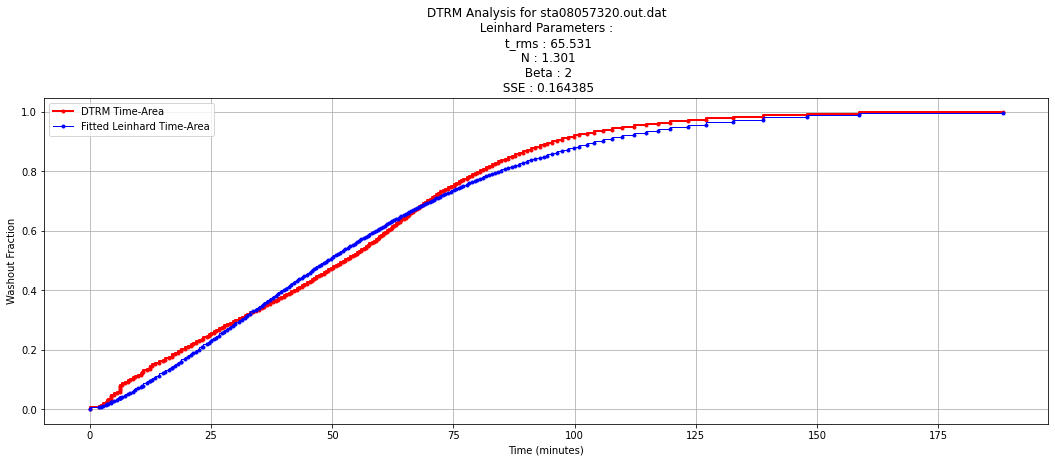

0.1643849812366717

In [25]:
result([res.x[0] , res.x[1]])